# Exploring Classification Methods: Music Genre Classification





## Author: Arash Sadeghzadeh





### Data for this notebook can be retrieved from the following URL:
https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification




## Table of Contents

* [Load Data](#zero-bullet)
* [Data Exploration and Cleaning](#first-bullet)
    - [Redundant features](#11-bullet)
    - [Distribution of the Data](#12-bullet)
    - [Encode Labels](#13-bullet)
    - [Determine Outliers](#14-bullet)
    - [Correlation Analysis](#15-bullet)
    - [Evaluation Functions](#16-bullet)
* [Classification Methods](#second-bullet)
    - [Logistic Regression](#21-bullet)
    - [Logistic Regression: L1, L2, ElasticNet](#22-bullet)
    - [K Nearest Neighbors](#23-bullet)
        - [Tune the number of neighbors](#231-bullet)
    - [Support Vector Machine](#24-bullet)
        - [Linear SVM](#241-bullet)
        - [SVM with kernel](#242-bullet)
    - [SVM with SGD Training](#25-bullet)
    - [Decision Tree Classifier](#26-bullet)
        - [Tune the hyperparameters](#261-bullet)
    - [Bagging Classifier](#27-bullet)
        - [Tune Parameter for Bagging Classifier](#271-bullet)
    - [Random Forest Classifier](#28-bullet)
    - [Extra Trees Classifier](#29-bullet)
        - [Extra Trees Classifier: Tuning Number of Estimators](#291-bullet)
    - [Gradient Boosting Classifier](#210-bullet)
    - [AdaBoost Classifier](#211-bullet)
        - [Tuning hyperparameter](#2111-bullet)
* [Results Comparison](#third-bullet)
* [Boosting and Stacking Models](#fourth-bullet)
    - [Voting Classifier: Soft voting](#41-bullet)
    - [Voting Classifier: Hard Voting](#42-bullet)
    - [Stacking Classifier: Using Prefit Models](#43-bullet)
    - [Stacking Classifier](#44-bullet)
* [Model Interpretability](#fifth-bullet)
    - [Permutation Feature Importance](#51-bullet)
    - [Partial Dependency Plot (PDP)](#52-bullet)
    - [Global Surrogate Model: Logistic Regression](#53-bullet)
* [Conclusion](#sixth-bullet)


In this notebook, different classification methods are explored and employed for the music genre classification. At first, data exploration and cleaning is carried out. Then, different classification methods are applied on our dataset. Subsequently, we consider boosting and stacking of the obtained models to improve the classification performance. Lastly, model interpretability is considered and explored for the final proposed model. 

## Load Data <a class="anchor" id="zero-bullet"></a>


Let us first load the data set and have a look at the different features.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pydotplus
import lime
import warnings

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, RocCurveDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn import tree
from io import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
from tqdm import tqdm
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

In [2]:
warnings.filterwarnings('ignore', module='sklearn')

In [3]:
data_name = 'features_3_sec.csv'
data = pd.read_csv(data_name)

data.head()
data_raw = data.copy()

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

## Data Exploration and Cleaning <a class="anchor" id="first-bullet"></a>


We have to clean the data to prepare it for the machine learning approaches. In this regard, we need to have a look at different features, delete the outliers, and explore the relationship between the features and the genres. Furthermore, we need to encode the classes to be able to apply the machine learning methods.


### Redundant features <a class="anchor" id="11-bullet"></a>

First, we investigate the features to delete those ones that do not provide any information.

In [5]:
unique_values =pd.DataFrame([[col, data[col].nunique()] for col in data.columns], columns=['Feature', 'Numeber of unique values'])
unique_values.set_index('Feature')
unique_values[unique_values['Numeber of unique values']<=10]

,Feature,Numeber of unique values
1,length,1
59,label,10


Since the length is similar for all the samples and filenames do not provide any information, we will drop them from the dataset.

In [6]:
data.drop(['length', 'filename'], axis=1, inplace=True)

### Distribution of the Data <a class="anchor" id="12-bullet"></a>

Now, let us have a look at the distribution of the genres in the label column of the dataset:

[Text(0.5, 0, 'Value'),
 Text(0, 0.5, 'Genre'),
 Text(0.5, 1.0, 'Distribution of Genres in the Dataset')]

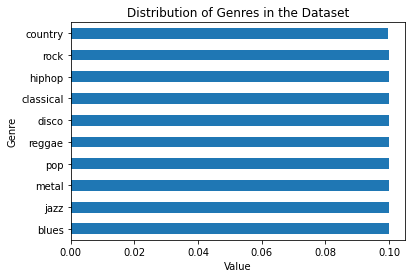

In [7]:
data.label.value_counts(normalize=True).plot.barh()
ax = plt.gca()
ax.set(xlabel='Value', ylabel='Genre', title='Distribution of Genres in the Dataset')

Obviousely, the numbers of different genres are the same in our dataset.

Now, let us explore the descriptive statistics of the dataset:

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
chroma_stft_mean,9990.0,3.795341e-01,9.046576e-02,1.071078e-01,0.315698,3.847409e-01,4.424433e-01,7.494808e-01
chroma_stft_var,9990.0,8.487615e-02,9.636622e-03,1.534475e-02,0.079833,8.510794e-02,9.109229e-02,1.209643e-01
rms_mean,9990.0,1.308591e-01,6.854539e-02,9.534877e-04,0.083782,1.212534e-01,1.763277e-01,4.425668e-01
rms_var,9990.0,2.676388e-03,3.585628e-03,4.379535e-08,0.000615,1.491318e-03,3.130862e-03,3.261522e-02
spectral_centroid_mean,9990.0,2.199219e+03,7.518606e+02,4.727416e+02,1630.680158,2.208628e+03,2.712582e+03,5.432534e+03
spectral_centroid_var,9990.0,4.166727e+05,4.349644e+05,8.118813e+02,123196.130771,2.650692e+05,5.624152e+05,4.794119e+06
spectral_bandwidth_mean,9990.0,2.241386e+03,5.438544e+02,4.991629e+02,1887.455790,2.230576e+03,2.588341e+03,3.708148e+03
spectral_bandwidth_var,9990.0,1.182711e+05,1.013505e+05,1.183520e+03,48765.526957,8.996072e+04,1.585674e+05,1.235143e+06
rolloff_mean,9990.0,4.566077e+03,1.642065e+03,6.583363e+02,3378.311110,4.631378e+03,5.591635e+03,9.487446e+03
rolloff_var,9990.0,1.628790e+06,1.489398e+06,1.145102e+03,559551.376085,1.160080e+06,2.262437e+06,1.298320e+07


### Encode Labels <a class="anchor" id="13-bullet"></a>

Since we have 10 different genres in our dataset, we need to encode the target labels with value between 0 and 9, as follows:

In [9]:
l_enc = LabelEncoder()
data['label'] = l_enc.fit_transform(data['label'])

y = data.label
X = data.drop('label', axis=1)

data_labels = list(l_enc.classes_)

### Determine Outliers <a class="anchor" id="14-bullet"></a>

Now, using boxplots, we graphically demonstrate the locality, spread, and skewness of the features through their quartiles as follows:

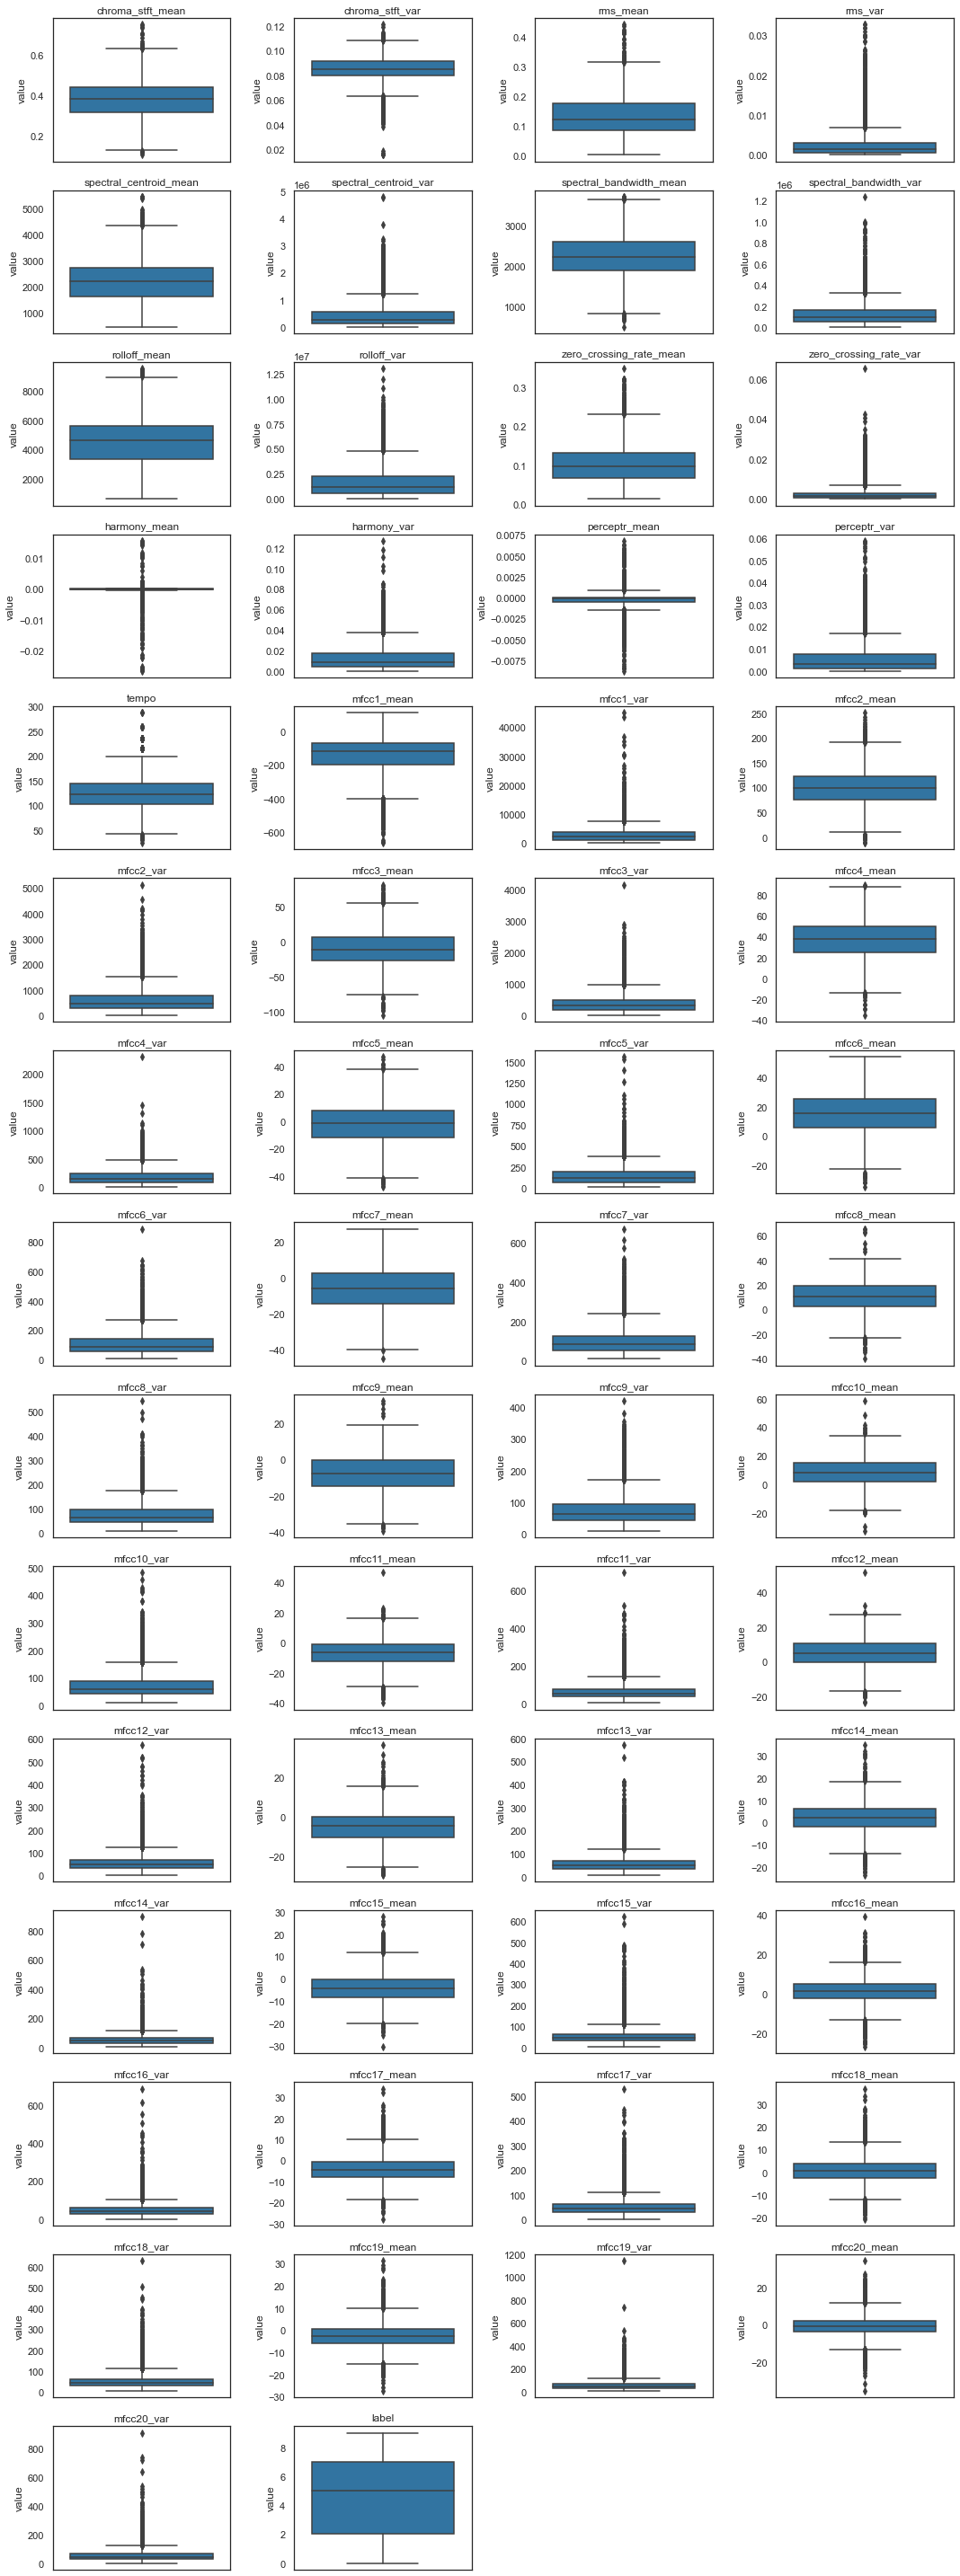

In [10]:
sns.set_context('notebook')
sns.set_style('white')

_, ax = plt.subplots(15,4, figsize=(15,40))
axs = ax.ravel()
for num, col in enumerate(data.columns):
    sns.boxplot(data=data[col], orient='v', ax=axs[num])
    axs[num].set_title(f'{data.columns[num]}')
    axs[num].set_ylabel('value')
    axs[num].set_xticklabels([''])

axs[58].axis('off')
axs[59].axis('off')
plt.tight_layout()
plt.show()

In what follows, we calculate the interquartile ranges to determine the bondary of the whiskers and decide which samples to be considered as outlier. Subsequently, we dertermine how many of the samples will lie out of the computed bounds.

Number of violations,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0
Number of samples,3442.0,2035.0,1785.0,823.0,542.0,387.0,274.0,225.0,123.0,123.0,...,44.0,22.0,10.0,10.0,4.0,8.0,3.0,3.0,1.0,1.0


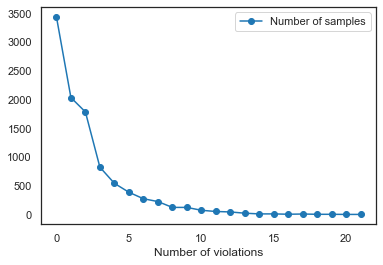

In [11]:
res = np.zeros(data.shape[0])
quan = data.quantile([0.25, 0.75])
Low_lim = quan.iloc[0] - 1.5 * (quan.iloc[1] - quan.iloc[0])
Up_lim = quan.iloc[1] + 1.5 * (quan.iloc[1] - quan.iloc[0])

for col in data.columns:
    mask = (data[col] < Low_lim[col]) | (data[col] > Up_lim[col])
    res += mask
    
out = pd.DataFrame(np.unique(res, return_counts=True),
                   index=['Number of violations', 'Number of samples']).T.set_index('Number of violations')
out.plot(marker='o')
out.T

In the above table and figure, you can see the numbers of samples that violate the defined bounds. For example, 3442 samples violate none of the bounds, 2035 samples just violate one limit ( lower or upper limit for one of the features) and so on. 

We have decided to delete those samples which violate more than 4 limits as follows:

In [12]:
data = data[res<5]
data.shape

(8627, 58)

So, after deleting the outliers, we still have 8627 samples in our dataset.

### Correlation Analysis <a class="anchor" id="15-bullet"></a>

Now, let us have a look at the correlations between the different columns of the dataset:

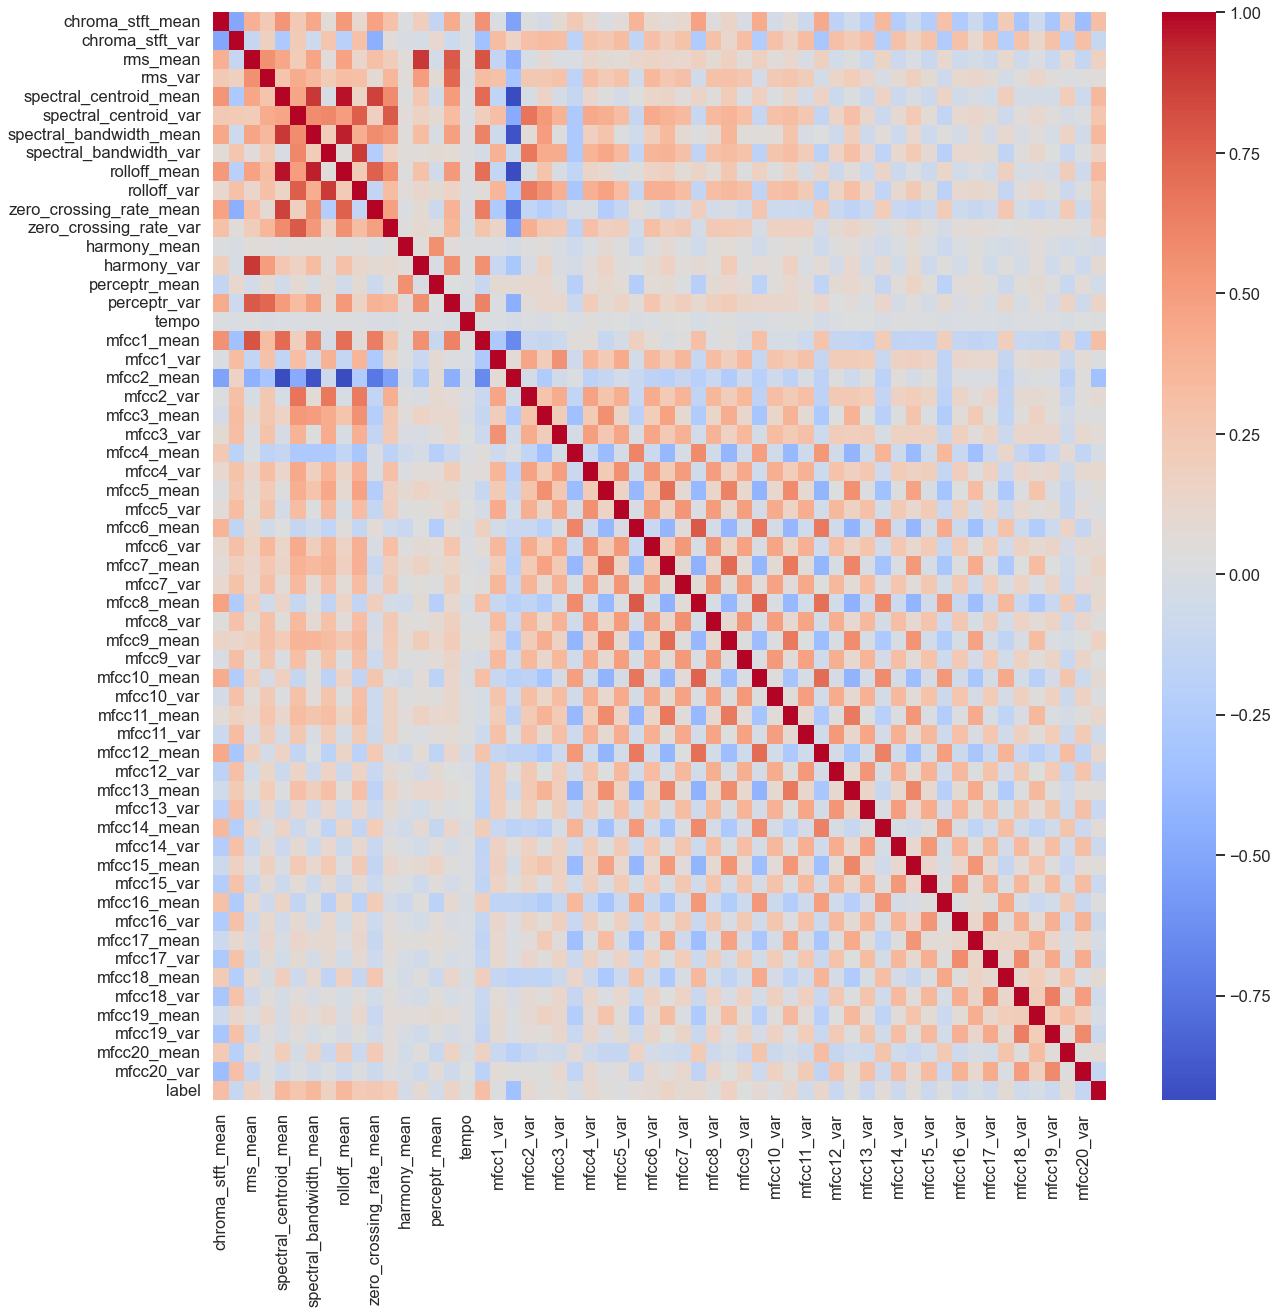

In [13]:
sns.set_context('talk')
sns.set_style('white')

plt.figure(figsize=(20,20))
corr_data = data.corr()
sns.heatmap(corr_data, cmap='coolwarm')
plt.show()

In what follows, one can see the correlation between the labels (genres) and the features:

<AxesSubplot:>

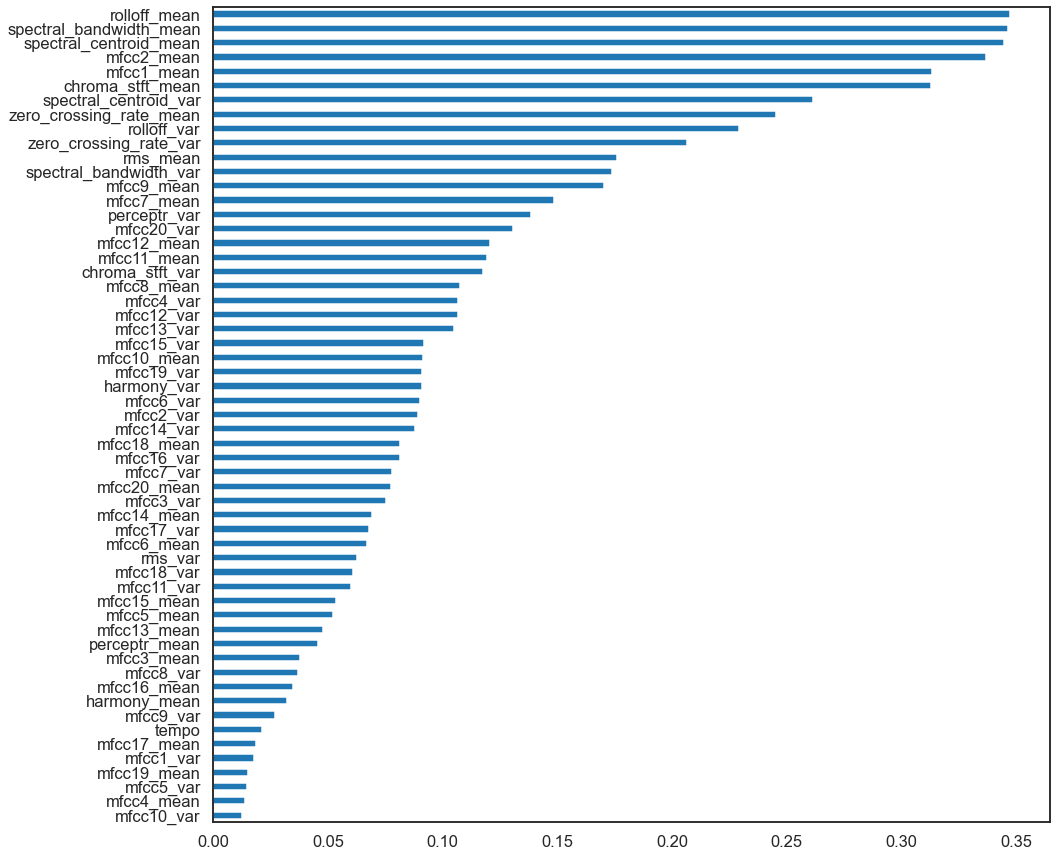

In [14]:
plt.figure(figsize=(15,15))
data_corr = data.corrwith(data['label']).drop('label').map(abs)
data_corr.sort_values().plot.barh()

### Evaluation Functions  <a class="anchor" id="16-bullet"></a>

To represent the results, we will later use the following functions:

In [15]:
def score_rates(method, X_tes_sca, y_tes, name):
    '''This is a function used to compute the related scores for the classifiers in
       this notebook.'''

    y_pred = method.predict(X_tes_sca)
    
    prec, reca, fsco,_ = precision_recall_fscore_support(y_true=y_tes, y_pred=y_pred, average='weighted')
    acc = accuracy_score(y_true=y_tes, y_pred=y_pred)
    
    y_pred_prob = method.predict_proba(X_tes_sca)
    roc = roc_auc_score(y_true=y_tes, y_score=y_pred_prob, average='weighted', multi_class='ovr')
    
    return pd.Series({'accuracy': acc, 'precision':prec, 'recall':reca, 'f1_score': fsco, 'roc_auc':roc}, name=name)

In [16]:
def depict_confusion_matrix(y_true, y_pred):
    '''This is a function to illustrate the confusion matrix
       for different classifiers we use in this notebook. '''
    sns.set_context('talk')
    sns.set_style('white')
    
    ConMat = confusion_matrix(y_true= y_true, y_pred=y_pred)
    plt.figure(figsize=(10,10))
    sns.heatmap(ConMat, annot=True, xticklabels=data_labels, yticklabels=data_labels, fmt='d', cmap='PuRd')
    ax = plt.gca()
    ax.set(xlabel='Prediction', ylabel='Ground Truth', title='Confusion Matrix')

## Classification Methods <a class="anchor" id="second-bullet"></a>

In this section, we will consider different classification methods for our dataset. We will apply different methods to our dataset and then will evaluat the obtained perfomance by each method utilizing appropriate scores and graphical representations. 

### Logistic Regression <a class="anchor" id="21-bullet"></a>

As the simplest method, we first apply logistic regression approach on our dataset:

In [17]:
X_tra, X_tes, y_tra, y_tes = train_test_split(X, y, test_size=0.2, random_state=1979, shuffle=True, stratify=y)

scaler = StandardScaler()
X_tra_sca = scaler.fit_transform(X_tra)
X_tes_sca = scaler.transform(X_tes)

LR_model = LogisticRegression(max_iter=10000, penalty='l1', solver='saga', n_jobs=-1)
LR_model.fit(X_tra_sca,y_tra)


LR_model.score(X_tes_sca, y_tes)
y_pred = LR_model.predict(X_tes_sca)

One can see the classification report: 

In [18]:
print(classification_report(y_true=y_tes, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74       200
           1       0.91      0.93      0.92       199
           2       0.67      0.66      0.66       199
           3       0.69      0.69      0.69       200
           4       0.76      0.62      0.69       200
           5       0.84      0.81      0.82       200
           6       0.84      0.89      0.86       200
           7       0.77      0.82      0.79       200
           8       0.67      0.73      0.70       200
           9       0.53      0.51      0.52       200

    accuracy                           0.74      1998
   macro avg       0.74      0.74      0.74      1998
weighted avg       0.74      0.74      0.74      1998



To evaluate the mode, let us have a look at some related scores:

In [19]:
LR_res = score_rates(LR_model, X_tes_sca, y_tes, 'Logistic Regression')
LR_res

accuracy     0.741742
precision    0.740910
recall       0.741742
f1_score     0.740276
roc_auc      0.957469
Name: Logistic Regression, dtype: float64

Let us save the obtained model for the further use:

In [20]:
CLF1 = make_pipeline(StandardScaler(), LR_model)
CLF1.fit(X_tra, y_tra)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1',
                                    solver='saga'))])

Additinally, lets have a look at the confusion matrix 

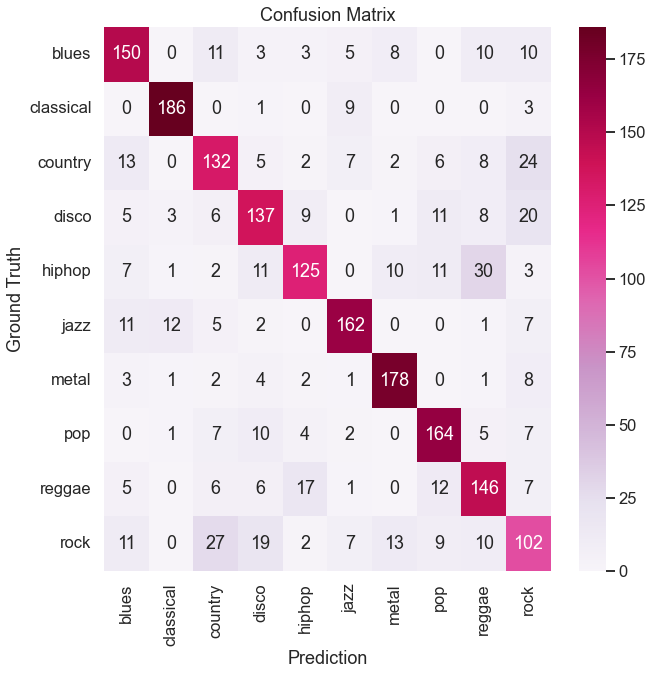

In [21]:
depict_confusion_matrix(y_true=y_tes, y_pred=y_pred)

### Logistic Regression: L1, L2, ElasticNet <a class="anchor" id="22-bullet"></a>

In this subsection, we will investigate the impact of different regularization approaches on the logistic regression models:

In [22]:
penalties = ['l1', 'l2', 'elasticnet']
kf = KFold(n_splits=5, shuffle=True, random_state=1979)

res_LR = list()

for penalty in penalties:
    LRCV = LogisticRegressionCV(Cs=np.geomspace(1e-1,1e1,3),
                         penalty= penalty,
                         n_jobs=-1,
                         max_iter=100,
                         scoring='accuracy',
                         solver='saga',
                         l1_ratios= np.linspace(0,1,3),
                         cv=kf)
    LRCV.fit(X_tra_sca, y_tra)
    res_LR.append(score_rates(LRCV, X_tes_sca, y_tes, 'Logistic Regression with ' + penalty))
    
metrics = pd.concat(res_LR, axis=1)
LRL1_res, LRL2_res, LREL_res = res_LR[0], res_LR[1], res_LR[2]
metrics

,Logistic Regression with l1,Logistic Regression with l2,Logistic Regression with elasticnet
accuracy,0.735235,0.735736,0.736236
precision,0.733809,0.734056,0.734763
recall,0.735235,0.735736,0.736236
f1_score,0.733519,0.733781,0.734491
roc_auc,0.956780,0.956817,0.956806


Above table gives a summarize of the application of different regularization methods on our dataset.

### K Nearest Neighbors <a class="anchor" id="23-bullet"></a>

Now, let us apply the K nearest neighbors classifier on our dataset to obtain another model.

In [23]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_tra_sca, y_tra)

KNeighborsClassifier(n_neighbors=3)

The following is the classification report:

In [24]:
y_pred = knn.predict(X_tes_sca)
print(classification_report(y_true=y_tes, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       200
           1       0.90      0.94      0.92       199
           2       0.84      0.83      0.83       199
           3       0.79      0.92      0.85       200
           4       0.92      0.85      0.89       200
           5       0.91      0.86      0.88       200
           6       0.97      0.95      0.96       200
           7       0.92      0.85      0.89       200
           8       0.91      0.94      0.93       200
           9       0.91      0.83      0.87       200

    accuracy                           0.89      1998
   macro avg       0.89      0.89      0.89      1998
weighted avg       0.89      0.89      0.89      1998



####  Tune the Number of Neighbors <a class="anchor" id="231-bullet"></a>

In this section, using cross-validate function, we look for the best value for K.

100%|███████████████████████████████████████████| 49/49 [00:12<00:00,  3.95it/s]


<AxesSubplot:xlabel='K'>

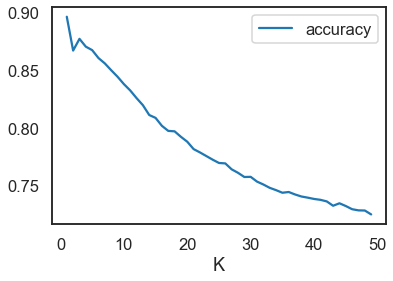

In [25]:
res_knn = list()

for k in tqdm(range(1,50)):
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(knn, X_tra_sca, y_tra, n_jobs=-1, cv=5, scoring='accuracy')
    sco = scores['test_score'].mean()
    res_knn.append([k, sco])
    
pd.DataFrame(res_knn, columns=['K', 'accuracy']).set_index('K').plot()

As one can see, the best performance is obtained by k=1.

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       200
           1       0.94      0.92      0.93       199
           2       0.88      0.82      0.85       199
           3       0.88      0.93      0.90       200
           4       0.93      0.93      0.93       200
           5       0.91      0.92      0.92       200
           6       0.99      0.97      0.98       200
           7       0.94      0.90      0.92       200
           8       0.93      0.96      0.95       200
           9       0.88      0.91      0.89       200

    accuracy                           0.92      1998
   macro avg       0.92      0.92      0.92      1998
weighted avg       0.92      0.92      0.92      1998



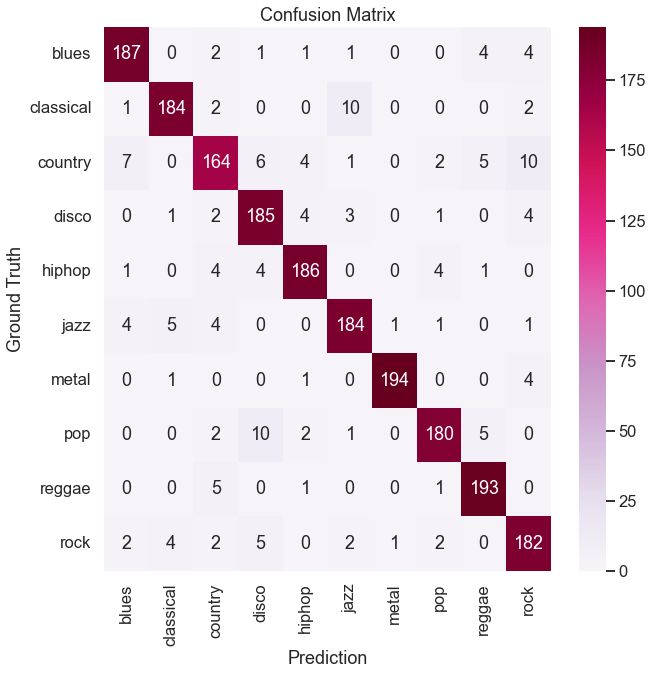

In [26]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_tra_sca, y_tra)
y_pred = knn.predict(X_tes_sca)

depict_confusion_matrix(y_true=y_tes, y_pred=y_pred)

print(classification_report(y_true=y_tes, y_pred=y_pred))

Lets have a look at some relevant scores:

In [27]:
KNN_res = score_rates(knn, X_tes_sca, y_tes, 'K Nearest Neighbors')
KNN_res

accuracy     0.920420
precision    0.920810
recall       0.920420
f1_score     0.920332
roc_auc      0.955789
Name: K Nearest Neighbors, dtype: float64

In [28]:
CLF2 = make_pipeline(StandardScaler(), knn)
CLF2.fit(X_tra, y_tra)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=1))])

### Support Vector Machine <a class="anchor" id="24-bullet"></a>

In this section, we apply support vector machine method on our dataset.

####  Linear SVM <a class="anchor" id="241-bullet"></a>

In [29]:
LSVM = LinearSVC(penalty='l2', random_state=1979, C=1)
LSVM.fit(X_tra_sca, y_tra)
y_pred = LSVM.predict(X_tes_sca)
print(classification_report(y_true=y_tes, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.70      0.77      0.73       200
           1       0.89      0.94      0.91       199
           2       0.62      0.63      0.63       199
           3       0.64      0.65      0.64       200
           4       0.74      0.56      0.63       200
           5       0.78      0.76      0.77       200
           6       0.79      0.92      0.85       200
           7       0.72      0.81      0.76       200
           8       0.59      0.69      0.63       200
           9       0.57      0.36      0.45       200

    accuracy                           0.71      1998
   macro avg       0.70      0.71      0.70      1998
weighted avg       0.70      0.71      0.70      1998



Please find below, the related scores for the linear SVM.

In [30]:
prec, reca, fsco,_ = precision_recall_fscore_support(y_true=y_tes, y_pred=y_pred, average='weighted')
acc = accuracy_score(y_true=y_tes, y_pred=y_pred)
    
LSVM_res = pd.Series({'accuracy': acc, 'precision':prec, 'recall':reca, 'f1_score': fsco, 'roc_auc':np.nan}, name='Linear SVM')
LSVM_res

accuracy     0.708208
precision    0.703711
recall       0.708208
f1_score     0.701010
roc_auc           NaN
Name: Linear SVM, dtype: float64

####  SVM with Kernel <a class="anchor" id="242-bullet"></a>

To improve the obtained classification performance, we consider using kernels for the SVM classification method.

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=1979)
pipe = Pipeline([('Scaler', scaler), ('Classifier', SVC())])

param_grid = {'Scaler': [StandardScaler(), MinMaxScaler(), MaxAbsScaler()],
              'Classifier__C': np.geomspace(1e-1,1e2,10),
              'Classifier__kernel': ['rbf', 'sigmoid', 'poly'],
              'Classifier__degree': [3, 5]}

SVM_GS = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring='accuracy', cv=kf)
SVM_GS.fit(X_tra, y_tra)


GridSearchCV(cv=KFold(n_splits=5, random_state=1979, shuffle=True),
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('Classifier', SVC())]),
             n_jobs=-1,
             param_grid={'Classifier__C': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ]),
                         'Classifier__degree': [3, 5],
                         'Classifier__kernel': ['rbf', 'sigmoid', 'poly'],
                         'Scaler': [StandardScaler(), MinMaxScaler(),
                                    MaxAbsScaler()]},
             scoring='accuracy')

In [32]:
SVM_GS.best_score_

0.9069069294717209

In [33]:
SVM_GS.best_params_

{'Classifier__C': 21.54434690031882,
 'Classifier__degree': 3,
 'Classifier__kernel': 'rbf',
 'Scaler': StandardScaler()}

In [34]:
SVM_GS.best_estimator_

Pipeline(steps=[('Scaler', StandardScaler()),
                ('Classifier', SVC(C=21.54434690031882))])

In [35]:
y_pred = SVM_GS.predict(X_tes)
print(classification_report(y_true=y_tes, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       200
           1       0.91      0.95      0.93       199
           2       0.88      0.90      0.89       199
           3       0.90      0.90      0.90       200
           4       0.94      0.89      0.91       200
           5       0.91      0.93      0.92       200
           6       0.97      0.97      0.97       200
           7       0.91      0.91      0.91       200
           8       0.92      0.96      0.94       200
           9       0.93      0.82      0.87       200

    accuracy                           0.92      1998
   macro avg       0.92      0.92      0.92      1998
weighted avg       0.92      0.92      0.92      1998



In [36]:
SVM = SVC(kernel=SVM_GS.best_params_['Classifier__kernel'], random_state=1979, 
          C=SVM_GS.best_params_['Classifier__C'], probability=True,
          degree=SVM_GS.best_params_['Classifier__degree'])

scaler = SVM_GS.best_params_['Scaler']

X_tra_sca = scaler.fit_transform(X_tra)
X_tes_sca = scaler.transform(X_tes)

SVM.fit(X_tra_sca, y_tra)
y_pred = SVM.predict(X_tes_sca)
print(classification_report(y_true=y_tes, y_pred=y_pred))

SVM_res = score_rates(SVM, X_tes_sca, y_tes, 'SVM with Kernel')
SVM_res

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       200
           1       0.91      0.95      0.93       199
           2       0.88      0.90      0.89       199
           3       0.90      0.90      0.90       200
           4       0.94      0.89      0.91       200
           5       0.91      0.93      0.92       200
           6       0.97      0.97      0.97       200
           7       0.91      0.91      0.91       200
           8       0.92      0.96      0.94       200
           9       0.93      0.82      0.87       200

    accuracy                           0.92      1998
   macro avg       0.92      0.92      0.92      1998
weighted avg       0.92      0.92      0.92      1998



accuracy     0.919920
precision    0.920174
recall       0.919920
f1_score     0.919546
roc_auc      0.995912
Name: SVM with Kernel, dtype: float64

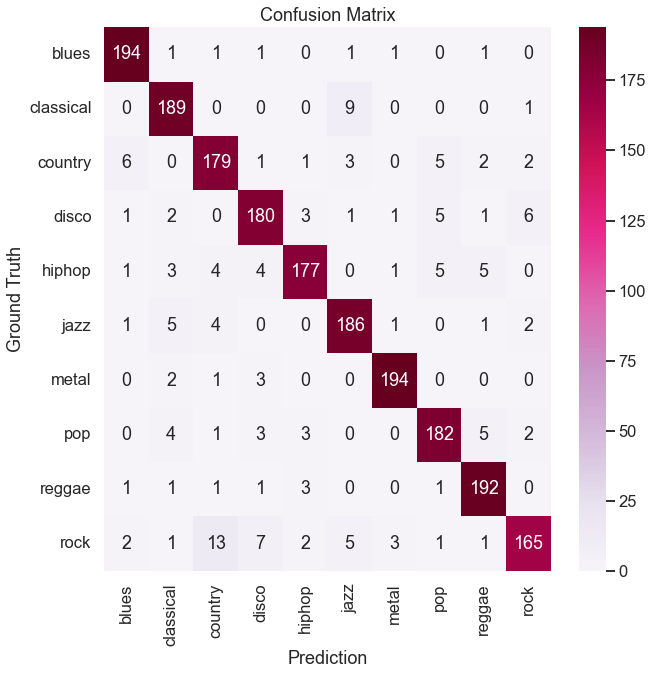

In [37]:
depict_confusion_matrix(y_true=y_tes, y_pred=y_pred)

Let us save the model for the later use:

In [38]:
CLF3 = make_pipeline(StandardScaler(), SVM)
CLF3.fit(X_tra, y_tra)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=21.54434690031882, probability=True,
                     random_state=1979))])

### SVM with SGD Training <a class="anchor" id="25-bullet"></a>

In this section, we use SVM with SGD training to obtain a model for the classification. 

In [39]:
feature_map_nystroem = Nystroem(gamma=0.05,random_state=1979, n_components=1000 )
X_tra_sca_tra= feature_map_nystroem.fit_transform(X_tra_sca)
X_tes_sca_tra = feature_map_nystroem.transform(X_tes_sca)

SGDC = SGDClassifier(loss='hinge', n_jobs=-1)
SGDC.fit(X_tra_sca_tra, y_tra)
y_pred = SGDC.predict(X_tes_sca_tra)

print(classification_report(y_true=y_tes, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.82      0.82      0.82       200
           1       0.73      0.96      0.83       199
           2       0.86      0.68      0.76       199
           3       0.79      0.76      0.77       200
           4       0.83      0.70      0.76       200
           5       0.80      0.82      0.81       200
           6       0.88      0.92      0.89       200
           7       0.79      0.83      0.81       200
           8       0.76      0.85      0.80       200
           9       0.80      0.68      0.74       200

    accuracy                           0.80      1998
   macro avg       0.81      0.80      0.80      1998
weighted avg       0.81      0.80      0.80      1998



In what follows, you can see the related scores for the obtained model.

In [40]:
prec, reca, fsco,_ = precision_recall_fscore_support(y_true=y_tes, y_pred=y_pred, average='weighted')
acc = accuracy_score(y_true=y_tes, y_pred=y_pred)
    
SGDC_res = pd.Series({'accuracy': acc, 'precision':prec, 'recall':reca, 'f1_score': fsco, 'roc_auc':np.nan}, name='SVM with SGD Training')
SGDC_res

accuracy     0.801301
precision    0.805627
recall       0.801301
f1_score     0.799295
roc_auc           NaN
Name: SVM with SGD Training, dtype: float64

### Decision Tree Classifier <a class="anchor" id="26-bullet"></a>

In this section, we apply the decision tree classifier on our dataset. A decision tree is a non-parametric supervised learning algorithm, which is utilized for both classification and regression tasks. 

In [41]:
DTC = DecisionTreeClassifier()
DTC.fit(X_tra, y_tra)

DecisionTreeClassifier()

Below, you can find the classification report for Decision Tree Classifier.

In [42]:
y_pred = DTC.predict(X_tes)
print(classification_report(y_true=y_tes, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.65      0.68      0.67       200
           1       0.88      0.88      0.88       199
           2       0.59      0.62      0.61       199
           3       0.57      0.60      0.59       200
           4       0.63      0.61      0.62       200
           5       0.72      0.76      0.74       200
           6       0.77      0.78      0.77       200
           7       0.73      0.62      0.67       200
           8       0.62      0.66      0.64       200
           9       0.48      0.43      0.45       200

    accuracy                           0.66      1998
   macro avg       0.66      0.66      0.66      1998
weighted avg       0.66      0.66      0.66      1998



Number of the nodes and the depth of the obtained tree are as follows:

In [43]:
DTC.tree_.node_count, DTC.tree_.max_depth

(2833, 26)

#### Tune the hyperparameters <a class="anchor" id="261-bullet"></a>

We use GridSearchCV to tune the hyperparameters of the Decision Tree Classifier:

In [44]:
DTC = DecisionTreeClassifier(random_state=1979)

param_grid = {'max_depth': np.linspace(1,26,13, dtype=int),
             'max_features': np.linspace(10,57,20, dtype=int),
             'criterion': ["gini", "entropy"]}

DTC_CV = GridSearchCV(DTC, n_jobs=-1, param_grid=param_grid)
DTC_CV.fit(X_tra, y_tra)

y_pred = DTC_CV.predict(X_tes)
print(classification_report(y_true=y_tes, y_pred=y_pred))

DTC_res = score_rates(DTC_CV, X_tes, y_tes, 'Decision Tree')
DTC_res

              precision    recall  f1-score   support

           0       0.70      0.63      0.66       200
           1       0.90      0.89      0.89       199
           2       0.56      0.57      0.57       199
           3       0.57      0.54      0.55       200
           4       0.65      0.68      0.66       200
           5       0.75      0.75      0.75       200
           6       0.71      0.81      0.75       200
           7       0.77      0.70      0.74       200
           8       0.63      0.71      0.67       200
           9       0.52      0.48      0.50       200

    accuracy                           0.68      1998
   macro avg       0.68      0.68      0.67      1998
weighted avg       0.68      0.68      0.67      1998



accuracy     0.675175
precision    0.675021
recall       0.675175
f1_score     0.674097
roc_auc      0.823135
Name: Decision Tree, dtype: float64

Let us save the model for the later use:

In [45]:
CLF4 = DTC_CV

In [46]:
DTC_CV.best_params_

{'criterion': 'entropy', 'max_depth': 15, 'max_features': 49}

### Bagging Classifier <a class="anchor" id="27-bullet"></a>

In this section, we consider Bagging Classifier method to obtain a model for the classification. 

In [47]:
DTC = DecisionTreeClassifier(criterion='entropy', max_depth=20)

BC = BaggingClassifier(base_estimator=DTC, n_estimators=1000, max_samples=6000, max_features=30, 
                       random_state=1979, n_jobs=-1)
BC.fit(X_tra, y_tra)
y_pred = BC.predict(X_tes)

print(classification_report(y_true=y_tes, y_pred=y_pred))

score_rates(BC, X_tes, y_tes, 'Bagging Classifier')

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       200
           1       0.92      0.95      0.94       199
           2       0.78      0.89      0.83       199
           3       0.85      0.81      0.83       200
           4       0.92      0.85      0.89       200
           5       0.88      0.89      0.88       200
           6       0.89      0.98      0.94       200
           7       0.91      0.85      0.88       200
           8       0.85      0.92      0.88       200
           9       0.90      0.72      0.80       200

    accuracy                           0.88      1998
   macro avg       0.88      0.88      0.88      1998
weighted avg       0.88      0.88      0.88      1998



accuracy     0.878378
precision    0.880542
recall       0.878378
f1_score     0.877510
roc_auc      0.990717
Name: Bagging Classifier, dtype: float64

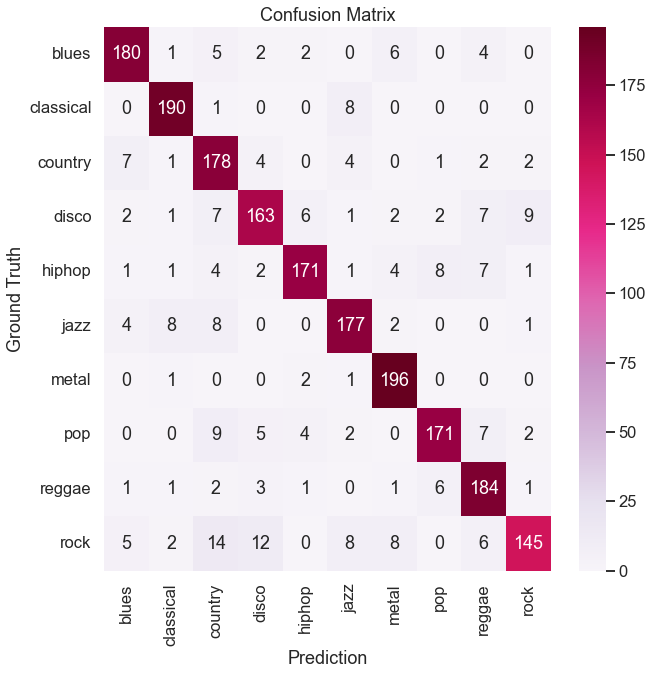

In [48]:
depict_confusion_matrix(y_true=y_tes, y_pred=y_pred)

####  Tune Parameter for Bagging Classifier <a class="anchor" id="271-bullet"></a>

In [49]:
kf = KFold(n_splits=5, shuffle=True, random_state=1979)
DTC = DecisionTreeClassifier()

BC = BaggingClassifier(base_estimator=DTC, random_state=1979, n_jobs=-1)

param_grid = {'n_estimators': np.linspace(100,1000,2, dtype=int),
              'max_samples': np.linspace(100,6000,2, dtype=int),
              'max_features': np.linspace(10,57,3, dtype=int),
              'base_estimator__max_depth': [10, 30],
              'base_estimator__criterion': ['entropy', 'gini']
               }

BC_CV = GridSearchCV(BC, param_grid=param_grid, n_jobs=-1, scoring='accuracy', cv=kf)
BC_CV.fit(X_tra, y_tra)

GridSearchCV(cv=KFold(n_splits=5, random_state=1979, shuffle=True),
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                         n_jobs=-1, random_state=1979),
             n_jobs=-1,
             param_grid={'base_estimator__criterion': ['entropy', 'gini'],
                         'base_estimator__max_depth': [10, 30],
                         'max_features': array([10, 33, 57]),
                         'max_samples': array([ 100, 6000]),
                         'n_estimators': array([ 100, 1000])},
             scoring='accuracy')

You can find below the obtained parameters of the best model:

In [50]:
BC_CV.best_params_

{'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 30,
 'max_features': 33,
 'max_samples': 6000,
 'n_estimators': 1000}

In [51]:
BC_CV.best_score_

0.8692458756685382

In [52]:
y_pred = BC_CV.predict(X_tes)
print(classification_report(y_true=y_tes, y_pred=y_pred))



              precision    recall  f1-score   support

           0       0.88      0.91      0.89       200
           1       0.93      0.95      0.94       199
           2       0.81      0.90      0.85       199
           3       0.85      0.81      0.83       200
           4       0.92      0.86      0.89       200
           5       0.89      0.89      0.89       200
           6       0.89      0.98      0.93       200
           7       0.92      0.85      0.89       200
           8       0.84      0.93      0.88       200
           9       0.89      0.72      0.80       200

    accuracy                           0.88      1998
   macro avg       0.88      0.88      0.88      1998
weighted avg       0.88      0.88      0.88      1998



Below, one can see the related scores for the obtained model:

In [53]:
BC_res = score_rates(BC_CV, X_tes, y_tes, 'Bagging Classifier')
BC_res

accuracy     0.879880
precision    0.881557
recall       0.879880
f1_score     0.878827
roc_auc      0.990799
Name: Bagging Classifier, dtype: float64

Let us save the model for the further use:

In [54]:
CLF4 = BC_CV

### Random Forest Classifier <a class="anchor" id="28-bullet"></a>

In what follows, we use random forest classifier method to obtain a model for our classification problem.

In [55]:
RFC = RandomForestClassifier(n_estimators=100, max_depth=20, n_jobs=-1, max_features='sqrt',
                             class_weight='balanced')
RFC.fit(X_tra, y_tra)
y_pred = RFC.predict(X_tes)
print(classification_report(y_true=y_tes, y_pred=y_pred))


              precision    recall  f1-score   support

           0       0.90      0.90      0.90       200
           1       0.90      0.95      0.93       199
           2       0.79      0.85      0.82       199
           3       0.82      0.81      0.82       200
           4       0.91      0.84      0.87       200
           5       0.89      0.88      0.89       200
           6       0.89      0.96      0.92       200
           7       0.90      0.84      0.87       200
           8       0.83      0.93      0.88       200
           9       0.83      0.69      0.75       200

    accuracy                           0.87      1998
   macro avg       0.87      0.87      0.86      1998
weighted avg       0.87      0.87      0.86      1998



In [56]:
RFC_res = score_rates(RFC, X_tes, y_tes, 'Random Forest Classifier')
RFC_res

accuracy     0.865365
precision    0.865819
recall       0.865365
f1_score     0.864084
roc_auc      0.989022
Name: Random Forest Classifier, dtype: float64

The obtaine dmodel is a s follows:

In [57]:
CLF5 = RFC

Let us have a look at the Feature Importance to understand which features are the moset relevant ones for the classification problem. 

<AxesSubplot:>

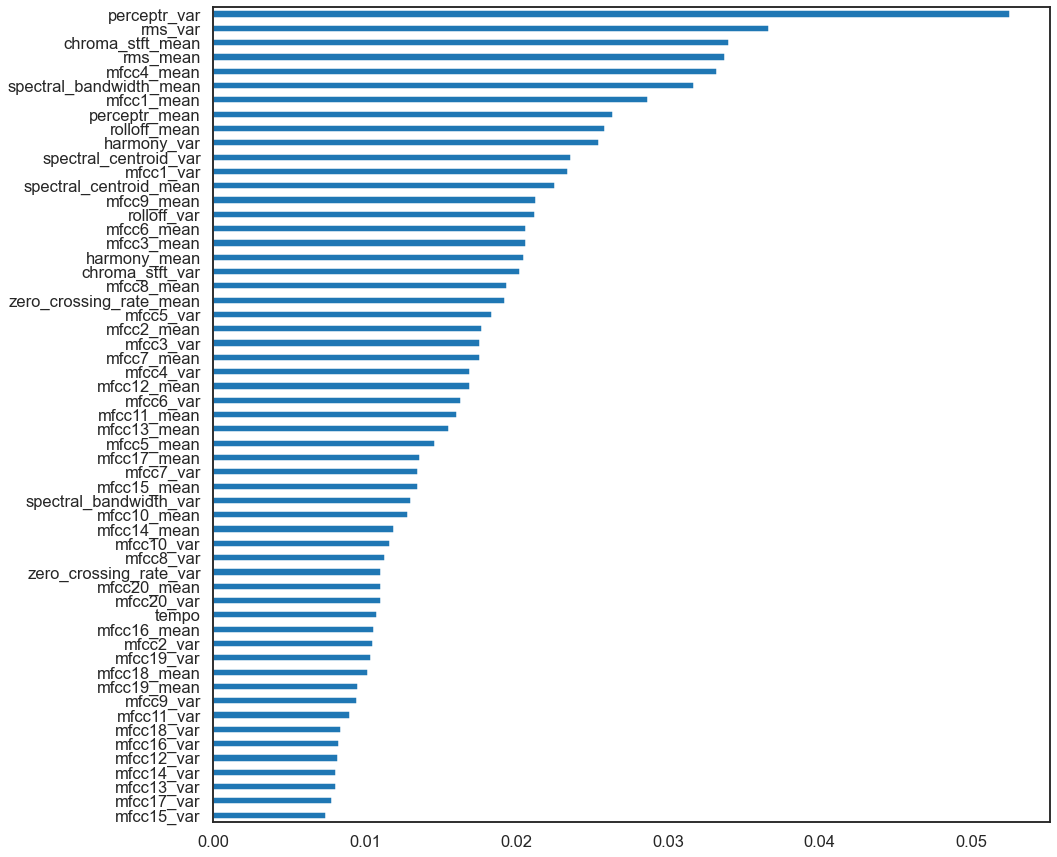

In [58]:
plt.figure(figsize=(15,15))
pd.Series(data=RFC.feature_importances_, index=X.columns).sort_values(ascending=True).plot.barh()

Let us explore the impact of the number of trees on the random forest classifier:

100%|███████████████████████████████████████████| 20/20 [00:12<00:00,  1.59it/s]


n_trees,20.0,70.0,120.0,170.0,220.0,270.0,320.0,370.0,420.0,470.0,520.0,570.0,620.0,670.0,720.0,770.0,820.0,870.0,920.0,970.0
oob,0.260761,0.163413,0.14502,0.137137,0.135761,0.132508,0.133884,0.131131,0.129004,0.12988,0.129505,0.128754,0.127252,0.12963,0.128879,0.125751,0.125125,0.126126,0.126877,0.12525


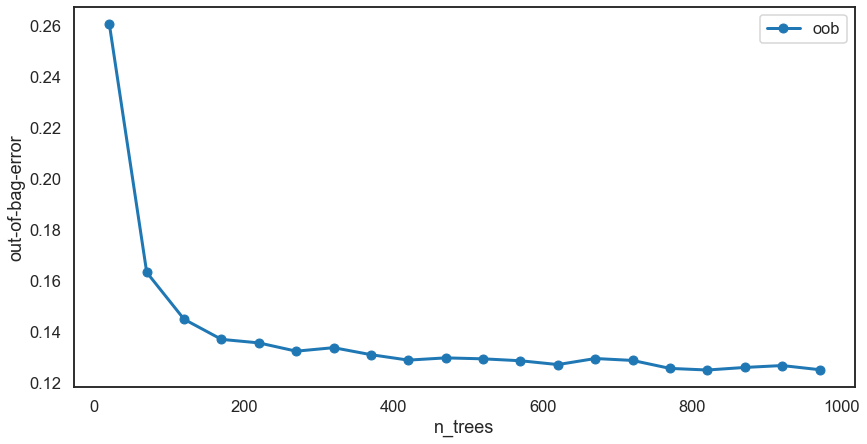

In [59]:
RFC = RandomForestClassifier(max_depth=20, n_jobs=-1, 
                             oob_score=True,
                             random_state=1979,
                             warm_start=True)
oob_list = list()

for n_trees in tqdm(range(20,1000,50)):
    
    RFC.set_params(n_estimators=n_trees)
    RFC.fit(X_tra, y_tra)
    oob_error = 1 - RFC.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

RF_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

sns.set_context('talk')
sns.set_style('white')
RF_oob_df.plot(linewidth=3, marker='o', figsize=(14,7), ylabel='out-of-bag-error')

RF_oob_df.T

### Extra Trees Classifier <a class="anchor" id="29-bullet"></a>

In this section, we consider the extra trees classifier.

In [60]:
ETC = ExtraTreesClassifier(n_estimators=1000, 
                           oob_score=True,
                           random_state=1979,
                           warm_start=True,
                           bootstrap=True,
                           n_jobs=-1)

ETC.fit(X_tra,y_tra)
y_pred = ETC.predict(X_tes)
print(classification_report(y_true=y_tes, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       200
           1       0.90      0.97      0.94       199
           2       0.80      0.88      0.84       199
           3       0.88      0.84      0.86       200
           4       0.91      0.83      0.87       200
           5       0.88      0.90      0.89       200
           6       0.92      0.97      0.94       200
           7       0.91      0.87      0.89       200
           8       0.80      0.93      0.86       200
           9       0.94      0.72      0.82       200

    accuracy                           0.88      1998
   macro avg       0.89      0.88      0.88      1998
weighted avg       0.89      0.88      0.88      1998



The obtained related scores are given below:

In [61]:
ETC_res = score_rates(ETC, X_tes, y_tes, 'Extra Trees Classifier')
ETC_res

accuracy     0.881882
precision    0.885312
recall       0.881882
f1_score     0.880948
roc_auc      0.990318
Name: Extra Trees Classifier, dtype: float64

Let us save the obtained model for the further use:

In [62]:
CLF6 = ETC

####  Extra Trees Classifier: Tuning Number of Estimators <a class="anchor" id="291-bullet"></a>

In this section, we consider tuning the number of estimators of the extra trees classifier.

100%|███████████████████████████████████████████| 20/20 [00:08<00:00,  2.25it/s]


<AxesSubplot:xlabel='n_trees', ylabel='out-of-bag-error'>

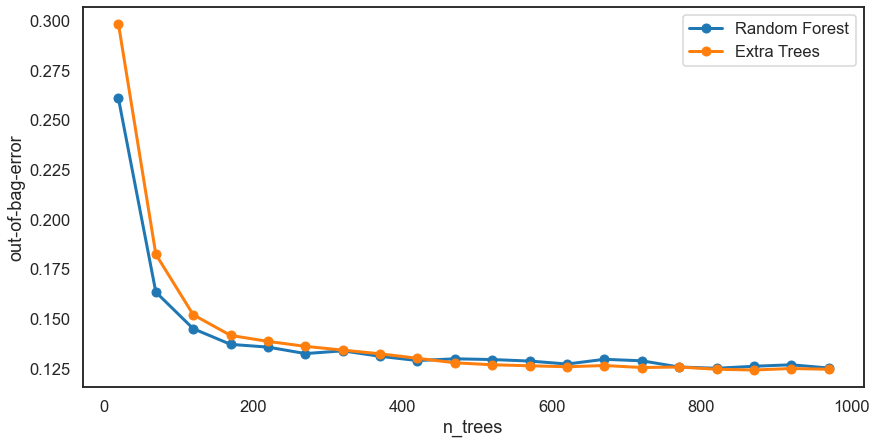

In [63]:
oob_list = list()
ETC = ExtraTreesClassifier(oob_score=True,
                           random_state=1979,
                           warm_start=True,
                           bootstrap=True,
                           n_jobs=-1)

for n_trees in tqdm(range(20,1000,50)):
    
    ETC.set_params(n_estimators=n_trees)
    ETC.fit(X_tra, y_tra)
    oob_error = 1 - ETC.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

ET_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

sns.set_context('talk')
sns.set_style('white')

oob_df = pd.concat([RF_oob_df.rename(columns={'oob': 'Random Forest'}),
                    ET_oob_df.rename(columns={'oob':'Extra Trees'})], axis=1)

oob_df.plot(linewidth=3, marker='o', figsize=(14,7), ylabel='out-of-bag-error')



### Gradient Boosting Classifier <a class="anchor" id="210-bullet"></a> 

In this section, we design a gradient boosting classifier for our classification problem.

In [64]:
GBC = GradientBoostingClassifier(n_estimators=1000,
                                 random_state=1979,
                                 max_features=10,
                                 max_depth=10,
                                learning_rate=0.05)

GBC.fit(X_tra,y_tra)
y_pred = GBC.predict(X_tes)
print(classification_report(y_true=y_tes, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       200
           1       0.92      0.94      0.93       199
           2       0.84      0.92      0.88       199
           3       0.91      0.86      0.89       200
           4       0.95      0.89      0.91       200
           5       0.89      0.91      0.90       200
           6       0.93      0.97      0.95       200
           7       0.94      0.88      0.90       200
           8       0.89      0.96      0.93       200
           9       0.92      0.84      0.88       200

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998



The obtained scores are as follows:

In [65]:
GBC_res = score_rates(GBC, X_tes, y_tes, 'Gradient Boosting Classifier')
GBC_res

accuracy     0.908909
precision    0.910141
recall       0.908909
f1_score     0.908730
roc_auc      0.993677
Name: Gradient Boosting Classifier, dtype: float64

Lets have a look at the confusion matrix:

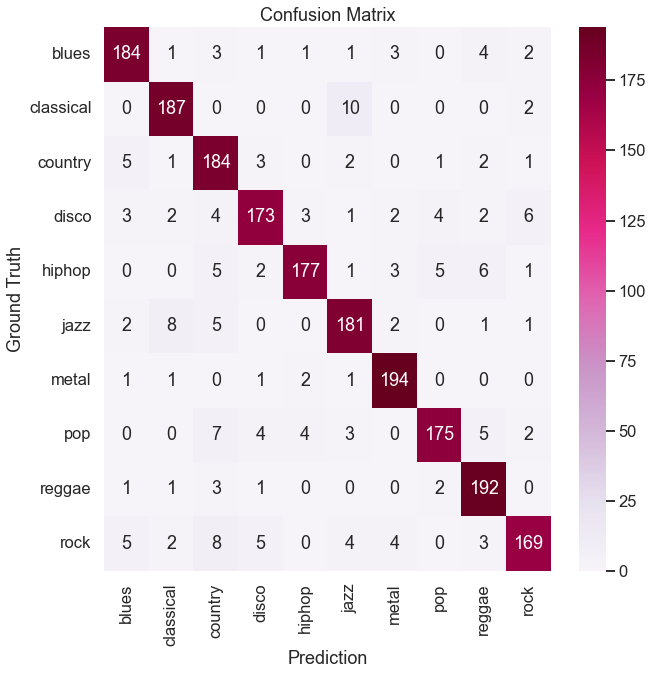

In [66]:
depict_confusion_matrix(y_true=y_tes, y_pred=y_pred)

Let us save the model for the further use:

In [67]:
CLF7 = GBC

### AdaBoost Classifier <a class="anchor" id="211-bullet"></a> 

In this section, we consider designing a classifier by AdaBoost algorithm. 

In [68]:
ABC = AdaBoostClassifier(n_estimators=1000,
                         base_estimator=DecisionTreeClassifier(max_depth=5),
                         random_state=1979,
                         learning_rate=0.5)
ABC.fit(X_tra,y_tra)
y_pred = ABC.predict(X_tes)
print(classification_report(y_true=y_tes, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.94      0.67      0.78       200
           1       0.97      0.75      0.85       199
           2       0.60      0.92      0.73       199
           3       0.72      0.79      0.75       200
           4       0.78      0.70      0.74       200
           5       0.79      0.83      0.81       200
           6       0.87      0.80      0.84       200
           7       0.93      0.65      0.76       200
           8       0.71      0.80      0.75       200
           9       0.60      0.74      0.67       200

    accuracy                           0.76      1998
   macro avg       0.79      0.76      0.77      1998
weighted avg       0.79      0.76      0.77      1998



Below, one can see the obtained scores:

In [69]:
ABC_res = score_rates(ABC, X_tes, y_tes, 'AdaBoost Classifier')
ABC_res

accuracy     0.764264
precision    0.793222
recall       0.764264
f1_score     0.767593
roc_auc      0.974155
Name: AdaBoost Classifier, dtype: float64

#### Tuning hyperparameter <a class="anchor" id="2111-bullet"></a> 

In this part, using GridSearchCV, we consider tuning the hyperparameter for the AdaBoost classifier.

In [70]:
kf = KFold(random_state=1979, n_splits=5, shuffle=True)
ABC = AdaBoostClassifier(DecisionTreeClassifier())

param_grid = {'n_estimators': np.geomspace(100,1000,5, dtype=int),
              'base_estimator__max_depth':[3, 5, 10],
              'learning_rate': [0.5, 1, 5]}

AB_CV = GridSearchCV(estimator=ABC, param_grid=param_grid, n_jobs=-1, scoring='accuracy', cv=kf)
AB_CV.fit(X_tra, y_tra)
y_pred = AB_CV.predict(X_tes)

In [71]:
AB_CV.best_score_

0.8562306228626934

In [72]:
AB_CV.best_estimator_

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),
                   learning_rate=1, n_estimators=1000)

Lets save the model for the later use:

In [73]:
CLF7 = AB_CV

## Results Comparison <a class="anchor" id="third-bullet"></a> 

Now that we have applied different methods to obtain classifiers for our dataset, we are able to comapre and summarize the results in this section:

In [74]:
round(pd.concat([LR_res, LRL1_res, LRL2_res, LREL_res, KNN_res, LSVM_res, SVM_res, SGDC_res, DTC_res, BC_res,
          RFC_res, ETC_res, GBC_res, ABC_res], axis=1), 3)

,Logistic Regression,Logistic Regression with l1,Logistic Regression with l2,Logistic Regression with elasticnet,K Nearest Neighbors,Linear SVM,SVM with Kernel,SVM with SGD Training,Decision Tree,Bagging Classifier,Random Forest Classifier,Extra Trees Classifier,Gradient Boosting Classifier,AdaBoost Classifier
accuracy,0.742,0.735,0.736,0.736,0.920,0.708,0.920,0.801,0.675,0.880,0.865,0.882,0.909,0.764
precision,0.741,0.734,0.734,0.735,0.921,0.704,0.920,0.806,0.675,0.882,0.866,0.885,0.910,0.793
recall,0.742,0.735,0.736,0.736,0.920,0.708,0.920,0.801,0.675,0.880,0.865,0.882,0.909,0.764
f1_score,0.740,0.734,0.734,0.734,0.920,0.701,0.920,0.799,0.674,0.879,0.864,0.881,0.909,0.768
roc_auc,0.957,0.957,0.957,0.957,0.956,NaN,0.996,NaN,0.823,0.991,0.989,0.990,0.994,0.974


As one can see, K Nearest Neighbors, SVM with kernel, and Gradient Boosting Classifier result in the best classifiers for our dataset.

## Boosting and Stacking Models <a class="anchor" id="fourth-bullet"></a> 

In this section, using the obtained models in the previous section, we consider boosting and stacking approaches to obtain a better model for our classification problem.

###  Voting Classifier: Soft voting <a class="anchor" id="41-bullet"></a> 

First, let us consider voting methodology by employing the top 3 models obtained in the previous section.

In [75]:
clf1 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))
clf2 = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=21.5, probability=True, random_state=1979))
clf3 = GradientBoostingClassifier(n_estimators=1000, random_state=1979, max_features=10, max_depth=10, learning_rate=0.05)

estimators = [('knn', clf1), ('svc', clf2), ('gbc', clf3)]

VC = VotingClassifier(estimators=estimators, n_jobs=-1, voting='soft')
VC.fit(X_tra, y_tra)
y_pred = VC.predict(X_tes)

print(classification_report(y_true=y_tes, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       200
           1       0.96      0.96      0.96       199
           2       0.90      0.93      0.92       199
           3       0.93      0.93      0.93       200
           4       0.96      0.92      0.94       200
           5       0.93      0.95      0.94       200
           6       0.98      0.98      0.98       200
           7       0.96      0.95      0.96       200
           8       0.94      0.97      0.96       200
           9       0.97      0.92      0.94       200

    accuracy                           0.95      1998
   macro avg       0.95      0.95      0.95      1998
weighted avg       0.95      0.95      0.95      1998



Lets have a look at the related scores:

In [76]:
VC_Soft_res = score_rates(VC, X_tes, y_tes, 'Voting Classifier: Soft Voting')
VC_Soft_res

accuracy     0.949950
precision    0.950358
recall       0.949950
f1_score     0.949944
roc_auc      0.997204
Name: Voting Classifier: Soft Voting, dtype: float64

As you can see, using voting classifier can improve the classifier performance for our dataset. 

Lets also have a look at the confusion matrix:

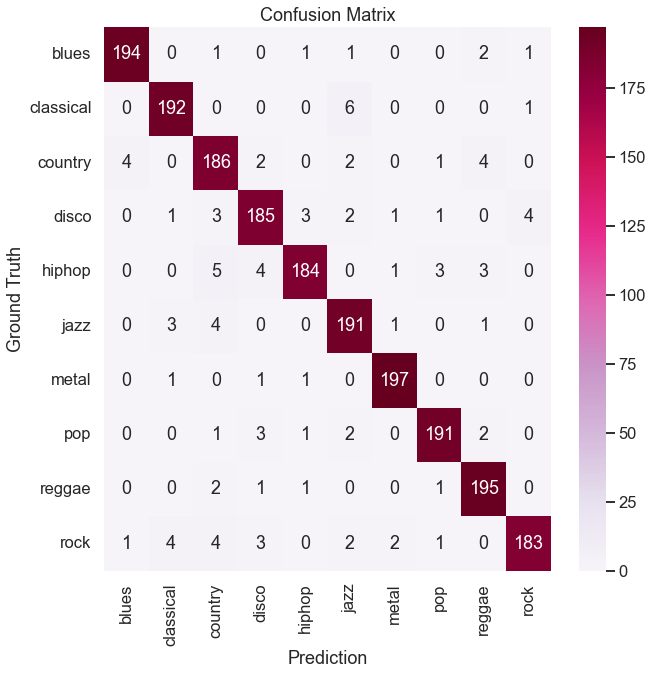

In [77]:
depict_confusion_matrix(y_true=y_tes, y_pred=y_pred)

### Voting Classifier: Hard Voting<a class="anchor" id="42-bullet"></a> 

Alternatively, we can employ voting methodology considering a 'hard voting' approach. We used the same models as in the previous subsection.

In [78]:
VC.set_params(voting='hard')

VotingClassifier(estimators=[('knn',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('kneighborsclassifier',
                                               KNeighborsClassifier(n_neighbors=1))])),
                             ('svc',
                              Pipeline(steps=[('standardscaler',
                                               StandardScaler()),
                                              ('svc',
                                               SVC(C=21.5, probability=True,
                                                   random_state=1979))])),
                             ('gbc',
                              GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=10,
                                                         max_features=10,
                                                         n_estimators=1000,
                                                         random_state=1979))],
                 n_jobs=-1)

Lets have a look at the classification report:

In [79]:
VC.fit(X_tra, y_tra)
y_pred = VC.predict(X_tes)

print(classification_report(y_true=y_tes, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       200
           1       0.91      0.96      0.94       199
           2       0.88      0.95      0.91       199
           3       0.93      0.92      0.93       200
           4       0.95      0.92      0.93       200
           5       0.94      0.94      0.94       200
           6       0.97      0.98      0.98       200
           7       0.97      0.92      0.94       200
           8       0.96      0.96      0.96       200
           9       0.98      0.89      0.93       200

    accuracy                           0.94      1998
   macro avg       0.94      0.94      0.94      1998
weighted avg       0.94      0.94      0.94      1998



The obtained scores are as follows:

In [80]:
prec, reca, fsco,_ = precision_recall_fscore_support(y_true=y_tes, y_pred=y_pred, average='weighted')
acc = accuracy_score(y_true=y_tes, y_pred=y_pred)
    
VC_hard_res = pd.Series({'accuracy': acc, 'precision':prec, 'recall':reca, 'f1_score': fsco, 'roc_auc':np.nan}, name='Voting Classifier: Hard Voting')
VC_hard_res

accuracy     0.940941
precision    0.942127
recall       0.940941
f1_score     0.940953
roc_auc           NaN
Name: Voting Classifier: Hard Voting, dtype: float64

###  Stacking Classifier: Using Prefit Models <a class="anchor" id="43-bullet"></a>

In this section, we use the stacking methodology to obtain a final model for our classification problem. To this purpose we use 7 classifiers we have already obtained in the previous section. 

In [81]:
Estimators = [('Logistic Regression', CLF1), ('K Nearest Neghbors', CLF2), ('Suport Vector Machines', CLF3),
              ('Bagging Classifier', CLF4), ('Random Farest', CLF5), ('Extra Trees', CLF6), ('AdaBoost', CLF7)]

SC_prefit = StackingClassifier(estimators=Estimators, final_estimator=LogisticRegression(), 
                        stack_method='auto', cv='prefit')

SC_prefit.fit(X_tra,y_tra)

y_pred = SC_prefit.predict(X_tes)

print(classification_report(y_true=y_tes, y_pred=y_pred))


              precision    recall  f1-score   support

           0       0.97      0.96      0.96       200
           1       0.96      0.96      0.96       199
           2       0.87      0.94      0.91       199
           3       0.92      0.93      0.92       200
           4       0.97      0.90      0.94       200
           5       0.92      0.93      0.92       200
           6       0.96      0.97      0.97       200
           7       0.95      0.92      0.93       200
           8       0.89      0.98      0.94       200
           9       0.96      0.85      0.90       200

    accuracy                           0.93      1998
   macro avg       0.94      0.93      0.93      1998
weighted avg       0.94      0.93      0.93      1998



In [82]:
SC_prefit_res = score_rates(SC_prefit, X_tes, y_tes, 'Stacking Classifier: Prefit Models')
SC_prefit_res

accuracy     0.934935
precision    0.936506
recall       0.934935
f1_score     0.934842
roc_auc      0.995518
Name: Stacking Classifier: Prefit Models, dtype: float64

One can see that the stacking of the classifiers can also lead to a better classification for our dataset. Note that we used the prefit classifiers in this section. 

### Stacking Classifier <a class="anchor" id="44-bullet"></a>

We use stacking classifier in this section with a Logistic Regression final estimator. 

In [83]:
clf1 = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))
clf2 = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=21.5, probability=True, random_state=1979))
clf3 = GradientBoostingClassifier(n_estimators=1000, random_state=1979, max_features=10, max_depth=10, learning_rate=0.05)

estimators = [('knn', clf1), ('svc', clf2), ('gbc', clf3)]

SC = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), stack_method='predict_proba', cv=5)
SC.fit(X_tra,y_tra)

y_pred = SC.predict(X_tes)

print(classification_report(y_true=y_tes, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       200
           1       0.97      0.96      0.96       199
           2       0.92      0.94      0.93       199
           3       0.94      0.91      0.93       200
           4       0.95      0.94      0.95       200
           5       0.92      0.94      0.93       200
           6       0.98      0.98      0.98       200
           7       0.95      0.96      0.95       200
           8       0.94      0.97      0.96       200
           9       0.94      0.94      0.94       200

    accuracy                           0.95      1998
   macro avg       0.95      0.95      0.95      1998
weighted avg       0.95      0.95      0.95      1998



In [84]:
SC_res = pd.Series({'accuracy': acc, 'precision':prec, 'recall':reca, 'f1_score': fsco, 'roc_auc':np.nan}, name='Voting Classifier: Hard Voting')
SC_res

accuracy     0.940941
precision    0.942127
recall       0.940941
f1_score     0.940953
roc_auc           NaN
Name: Voting Classifier: Hard Voting, dtype: float64

## Model Interpretability <a class="anchor" id="fifth-bullet"></a>

In this section, we tackle the problem of model interpretability. The model that we use in this section is the model obtained by the Stacking classifier.

### Permutation Feature Importance <a class="anchor" id="51-bullet"></a>

First, using the permutation_importance, we investigate the most relevant features for our classification problem. 

In [85]:
feature_importances = permutation_importance(estimator=SC, X=X_tra, y=y_tra,
                                             n_repeats=10, n_jobs=-1)


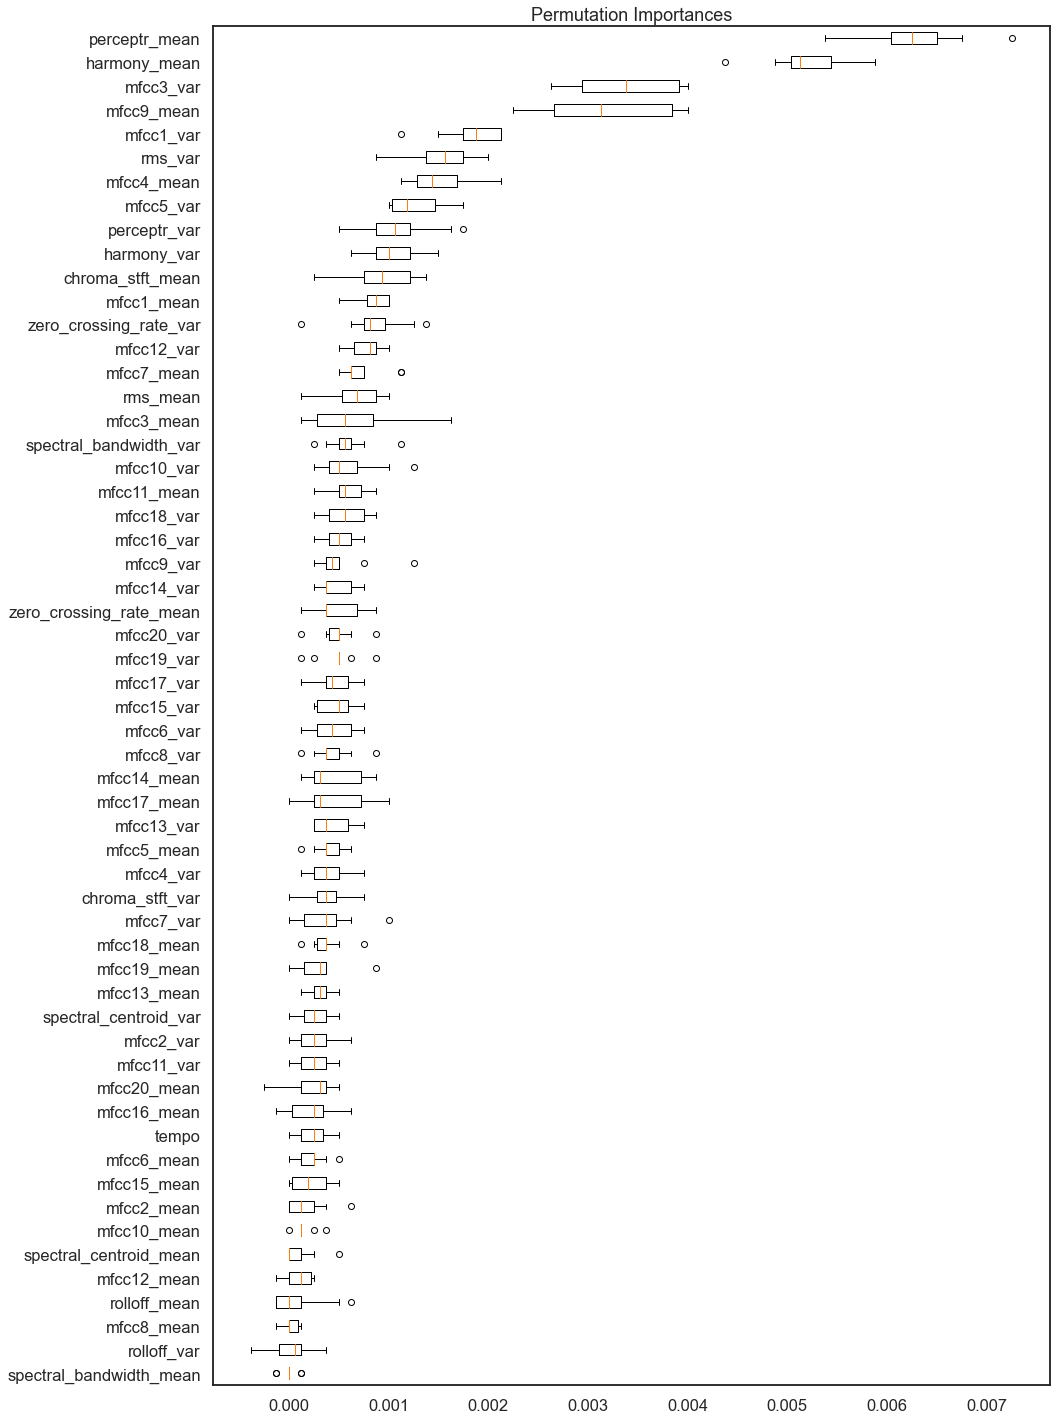

In [86]:
sorted_idx = feature_importances.importances_mean.argsort()

plt.figure(figsize=(15,25))
plt.boxplot(feature_importances.importances[sorted_idx].T,
            vert=False, labels=X_tra.columns[sorted_idx])
plt.title('Permutation Importances')
plt.show()

As one can see, perceptr_mean, harmony_mean, and mfcc3_bar are the top three features used for the classification.

### Partial Dependency Plot (PDP) <a class="anchor" id="52-bullet"></a>

In this section, using Partial Dependency Plot (PDP), we investigate the marginal effect the top 3 most relevant features have on the predicted outcome of our model. Here, again, we use the model obtained by the stacking classifier in the previous section. To simplify the represenation, we have considered the feature imacts on the prediction of class zero ('blues').

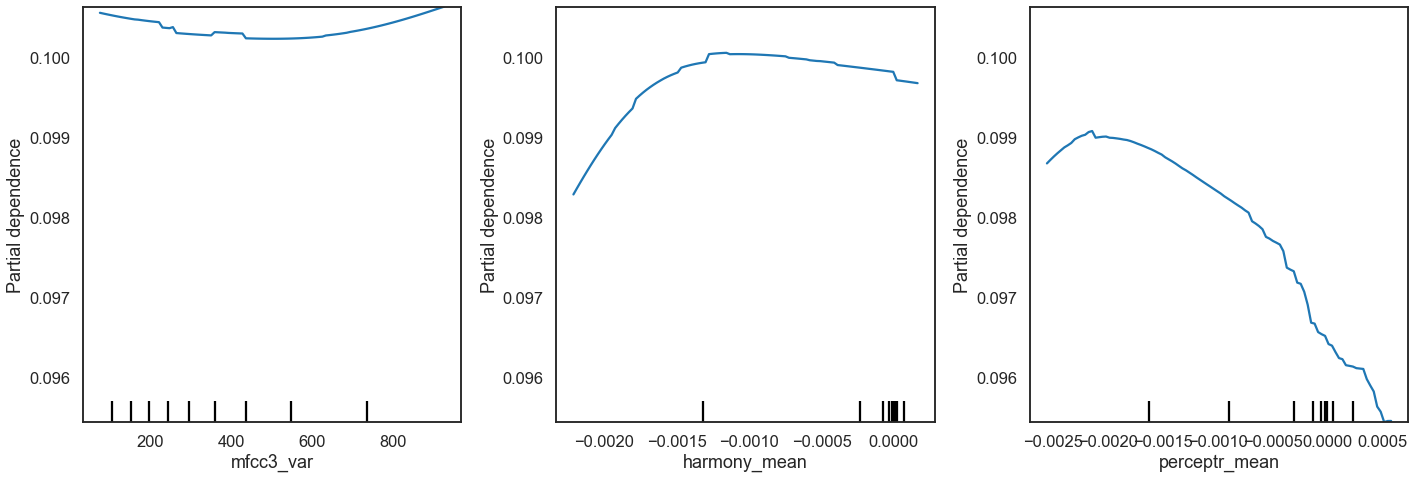

In [87]:
# choose the desired features
selected_features = X_tra.columns[sorted_idx[-3:]]

# choose the desired output class
target_class = 0

_, ax = plt.subplots(1,3, figsize=(20,7))

PartialDependenceDisplay.from_estimator(estimator=SC, X=X_tra, features=selected_features,

                                        target=target_class, random_state=1979, n_jobs=-1, ax=ax)
plt.tight_layout()
plt.show()

### Global Surrogate Model: Logistic Regression <a class="anchor" id="53-bullet"></a>


In this section, a global surrogate model, which is an interpretable model,  is trained to approximate the prediction of the model obtained by stacking the classifiers (blackbox model). 

In [88]:
# Blackbox output
y_bb = SC.predict(X_tes)

X_tes_sca = StandardScaler().fit_transform(X_tes)
sur_mod = LogisticRegression(random_state=1979, penalty='l2', solver='liblinear')
sur_mod.fit(X_tes_sca, y_bb)

y_sur_mod_pre = sur_mod.predict(X_tes_sca)
print('The accuracy score between the surrogate model and the blackbox model: {}'.format(accuracy_score(y_true=y_bb, y_pred=y_sur_mod_pre)))

The accuracy score between the surrogate model and the blackbox model: 0.7577577577577578


The accuracy score given above reveals the degree of quality of the surrogate model considering the fact that the surrogate model is an approximation of the blackbox model.

The following function is used for the representation of the results.

In [89]:
def set_color(reg_coef):
    col = list()
    mask = reg_coef>0
    for elem in mask:
        if elem:
            col.append('g')
        else:
            col.append('r') 
    return col

In what follows, we depict the coefficients of the logistic regression surrogate model for different output labels.

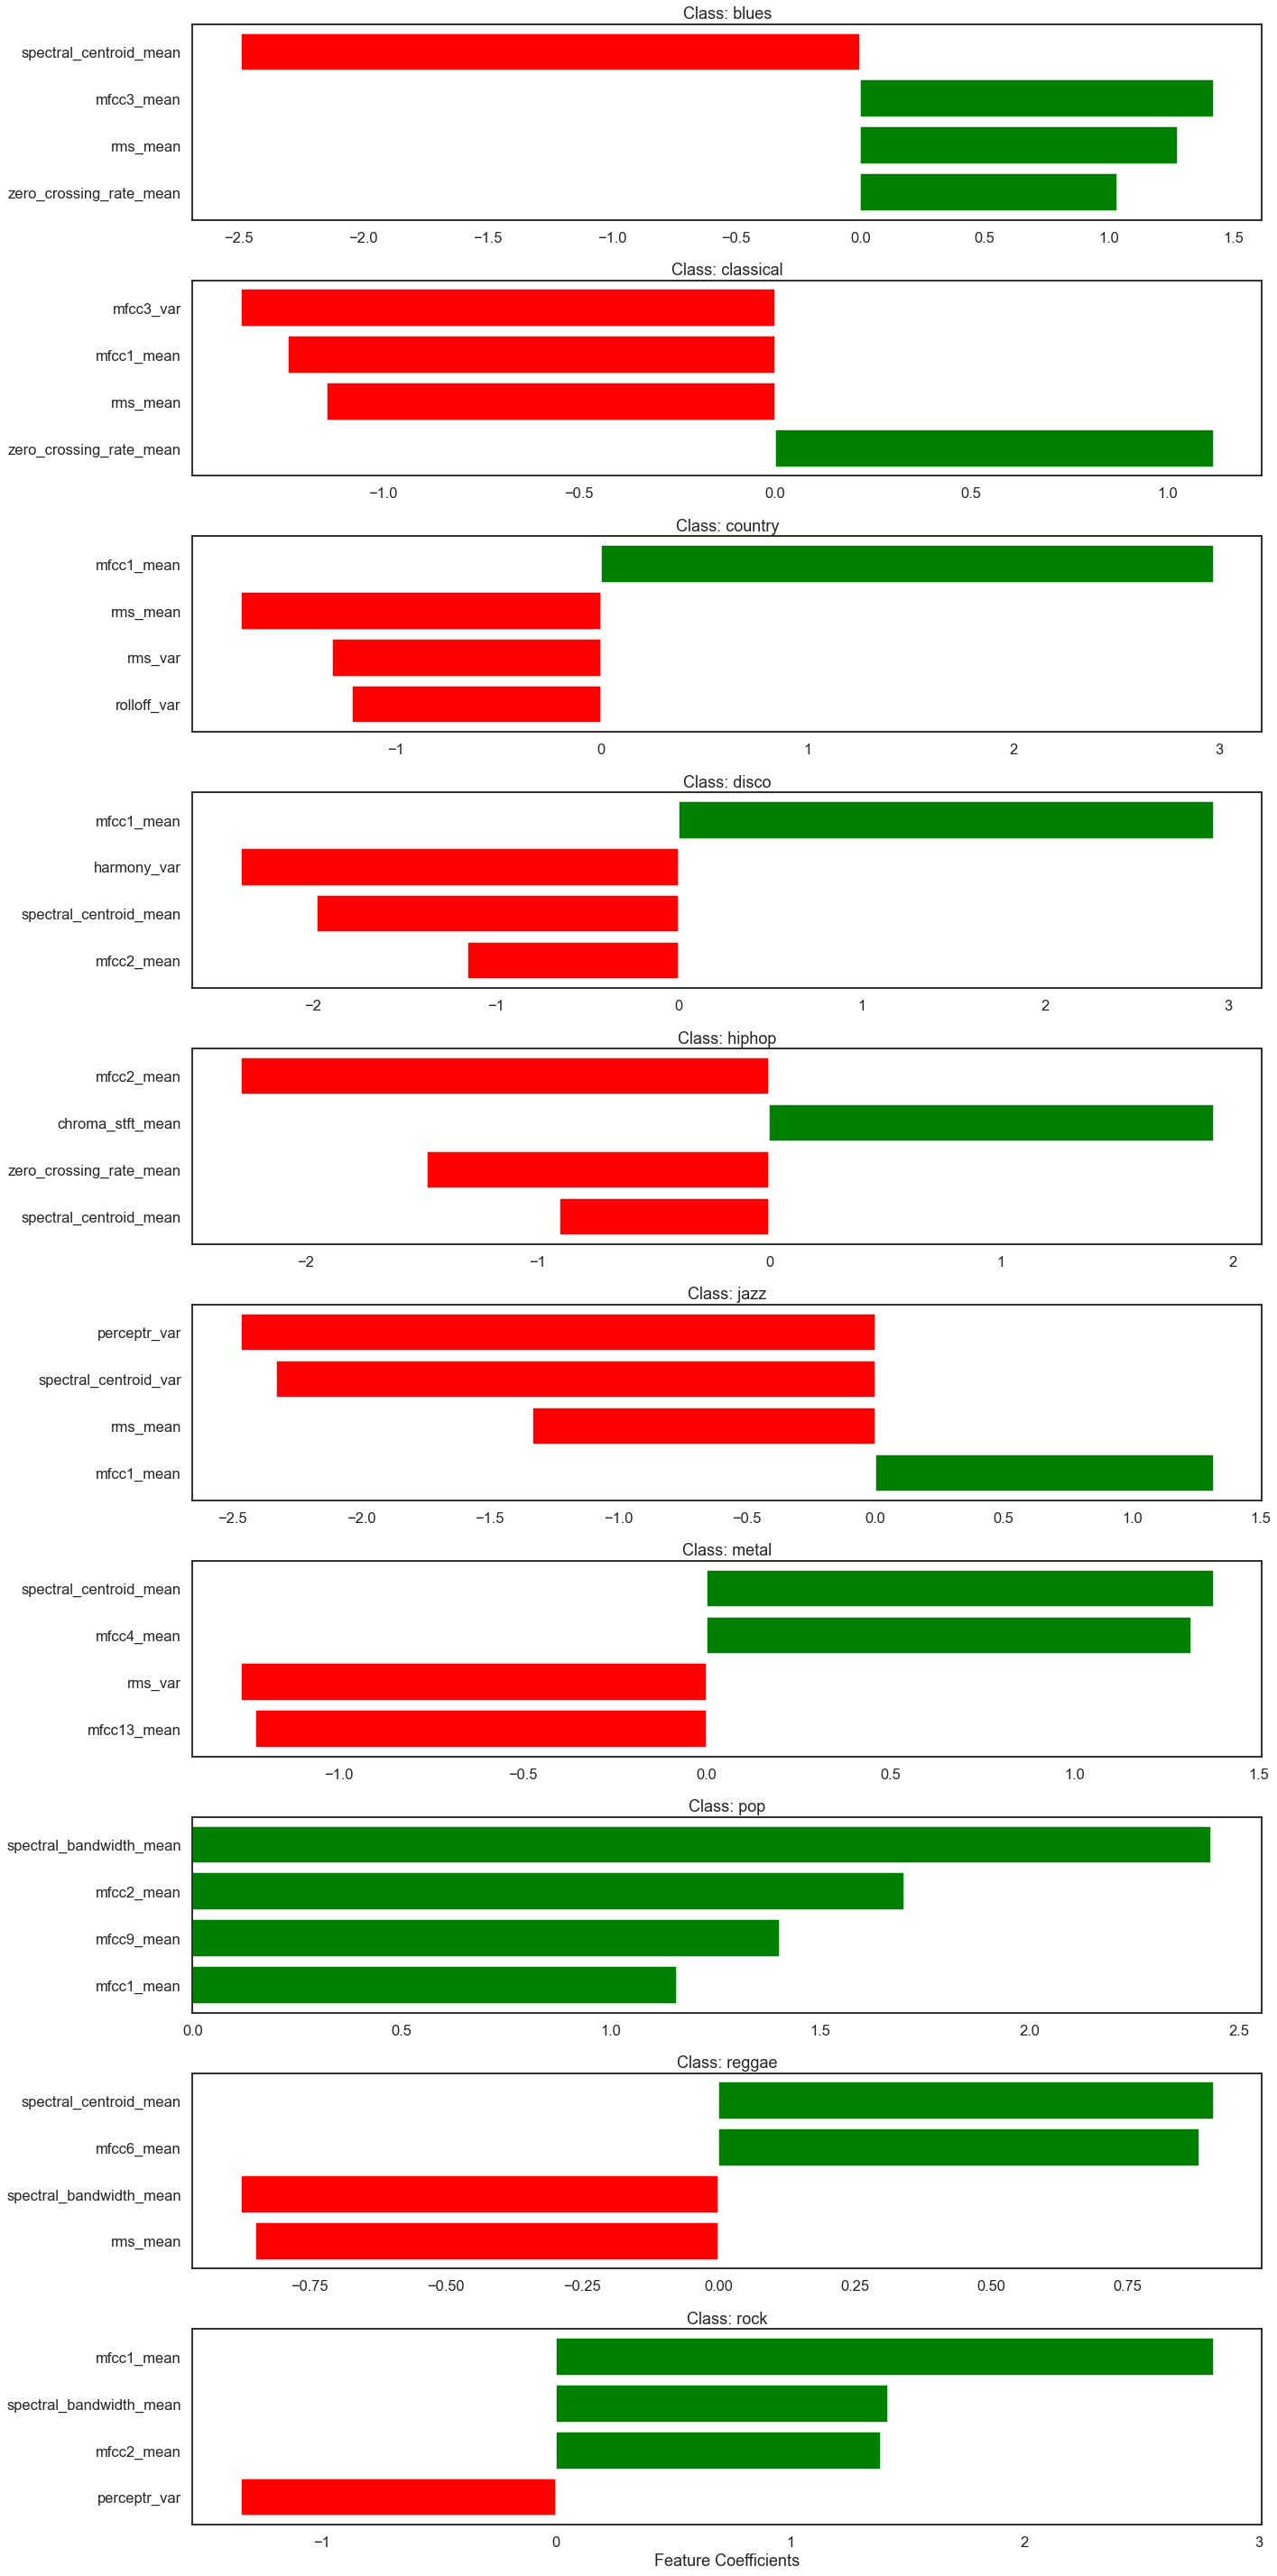

In [90]:
fig, ax =plt.subplots(10,1, figsize=(20,40))
axs = ax.ravel()

for num,row in enumerate(sur_mod.coef_):
    idx_sort = np.argsort(row)
    labels = X_tra.columns[idx_sort]
    row_sorted = row[idx_sort]
    
    # Select those features whose absolute values are greater than 1 
    mask = np.argsort(abs(row_sorted))[-4:]
    axs[num].barh(labels[mask], row_sorted[mask], color=set_color(row_sorted[mask]), align='center')
    axs[num].set_title('Class: {}'.format(data_labels[num])) 
    
plt.xlabel('Feature Coefficients')
plt.tight_layout()
plt.show()

Based on this figure, for instance for the class 'blues', spectral_centroid_mean, mfcc3_mean, rms_mean, and zero_crossing_rate_mean are the top 4 significant features. As one can see, to predict a music as 'blues', the first feature (spectral_centroid_mean) has the negetive impact and the other 3 mentioned features have the positive impact to predict a music genre as 'blues'.

## Conclusion <a class="anchor" id="sixth-bullet"></a>

To recapitulate, we explored different classification methods in this notebook. As an example, we applied the available methods on music genre classification problem. The model obtained by different methods were compared. Then, we exploited bagging, boosting, and stacking methodologies to improve the classification performance. Finally, using model interpretability approaches, we drew conclusions about our final proposed model for the classification problem. 